In [2]:
# Add the path to the Utils folder
import sys
import tensorflow as tf
sys.path.append('../Utils')

from notebookUtils import visualize_class_distribution

# EDA

## Contents
- [Looking at Class Distribution of train, validate, and test sets](#looking-at-class-distribution-of-train-validate-and-test-sets)
- [Getting insights into Class Distribution](#getting-insights-into-class-distribution)
- [Finding a better Class Distribution](#finding-a-better-class-distribution)
- [Decision: threshold=80 may be the best](#decision-threshold80-may-be-the-best)

## Looking at Class Distribution of train, validate, and test sets

Processing files:   0%|          | 0/7938 [00:00<?, ?file/s]

d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 7938/7938 [08:20<00:00, 15.85file/s]


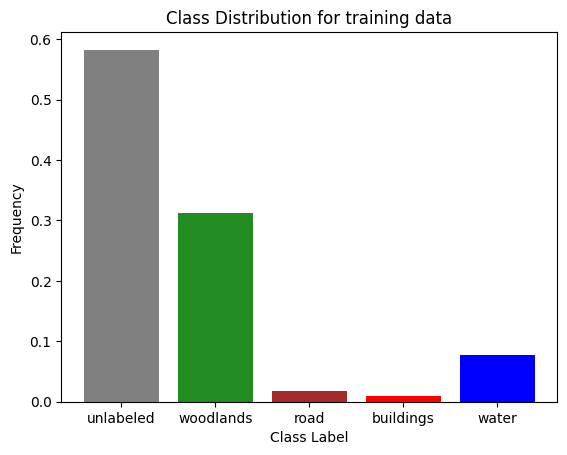

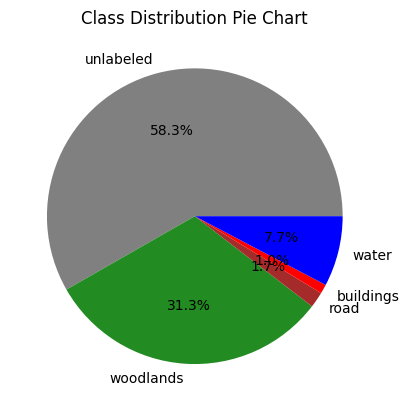

Class Distribution Summary:
unlabeled: 1212485466 samples, 58.27%
woodlands: 651250397 samples, 31.30%
road: 36019481 samples, 1.73%
buildings: 20982911 samples, 1.01%
water: 160160817 samples, 7.70%


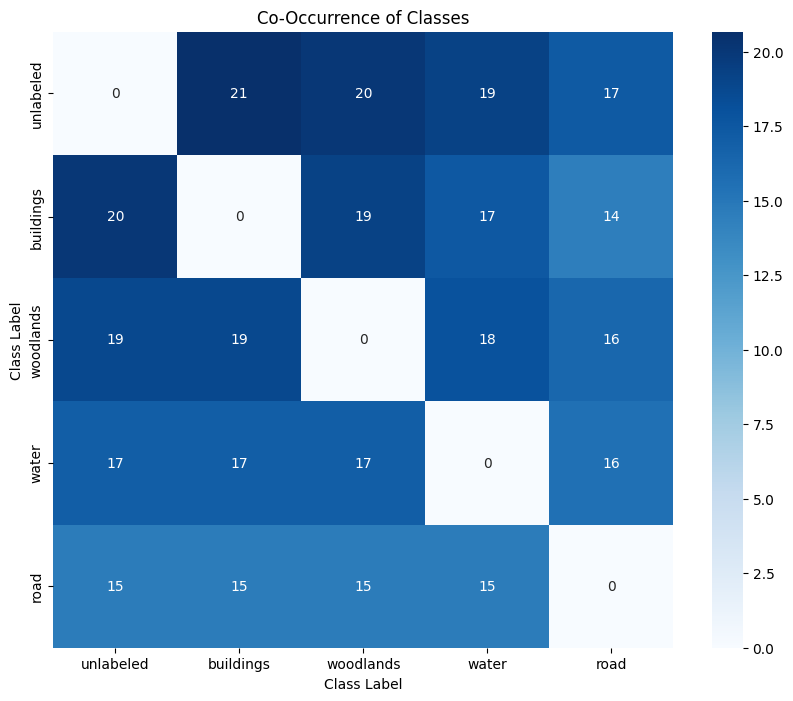

In [ ]:
# Define the path to the training ground truth folder
gt_folder = './../Data/train/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for training data')

Processing files:   0%|          | 0/990 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 990/990 [00:40<00:00, 24.32file/s]


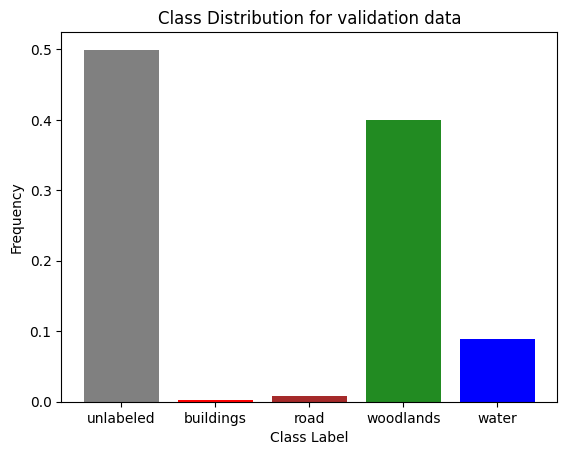

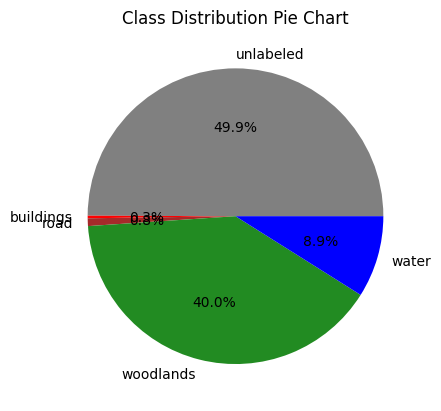

Class Distribution Summary:
unlabeled: 129628988 samples, 49.95%
buildings: 715881 samples, 0.28%
road: 2190542 samples, 0.84%
woodlands: 103796083 samples, 40.00%
water: 23191066 samples, 8.94%


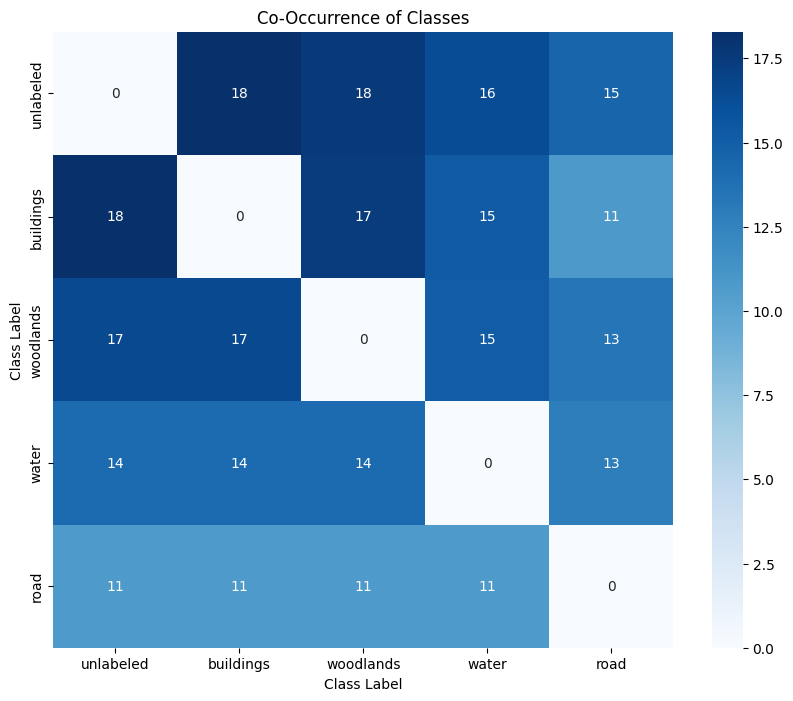

In [ ]:
# Define the path to the training ground truth folder
gt_folder = './../Data/validate/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for validation data')

Processing files:   0%|          | 0/1296 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 1296/1296 [00:57<00:00, 22.41file/s]


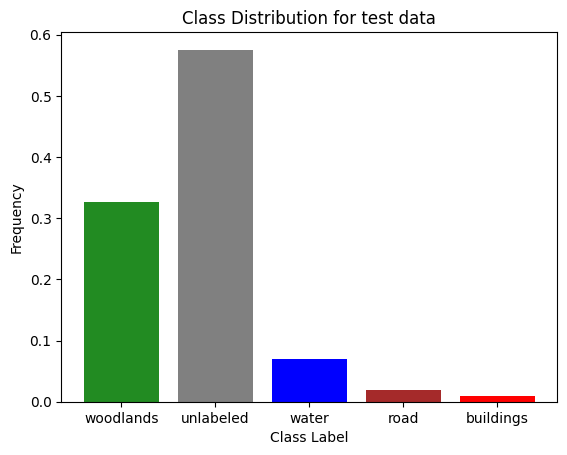

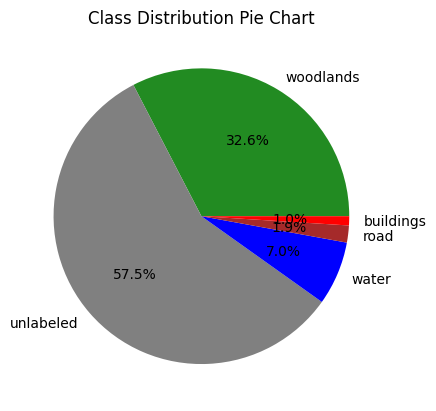

Class Distribution Summary:
woodlands: 110786661 samples, 32.61%
unlabeled: 195496667 samples, 57.54%
water: 23730250 samples, 6.98%
road: 6322836 samples, 1.86%
buildings: 3402210 samples, 1.00%


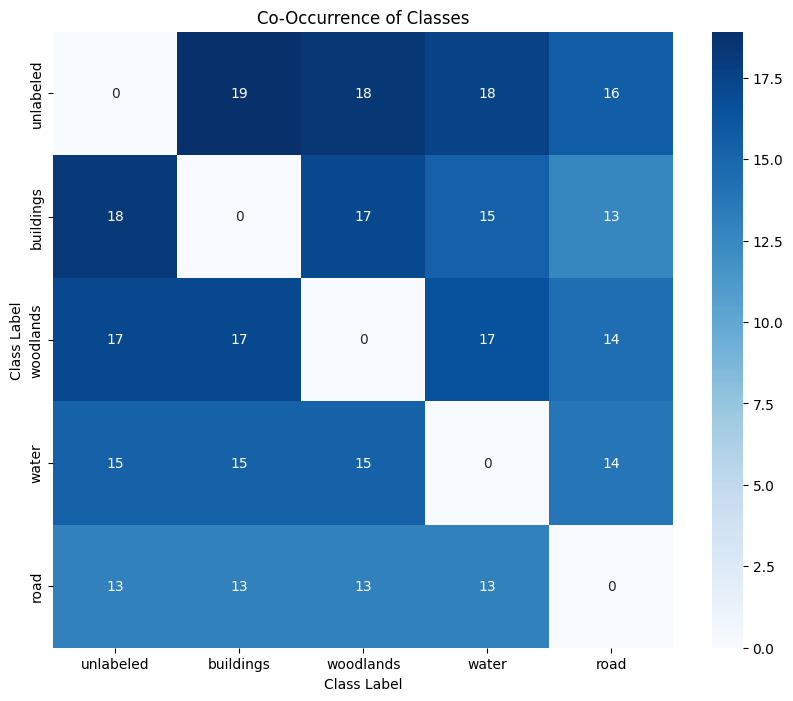

In [ ]:
# Define the path to the training ground truth folder
gt_folder = './../Data/test/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for test data')

## Getting insights into Class Distribution

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def visualize_image_pairs(sat_folder, gt_folder, num_samples=5):
    # Define colors for each class
    class_colors = {
        0: (0, 0, 0),        # unlabeled
        1: (255, 0, 0),      # buildings
        2: (34, 139, 34),    # woodlands
        3: (0, 0, 255),      # water
        4: (184, 115, 51)    # road
    }

    # Get a list of image files in the folders
    sat_files = os.listdir(sat_folder)
    gt_files = os.listdir(gt_folder)

    # Randomly sample image files
    sampled_files = random.sample(sat_files, min(num_samples, len(sat_files)))

    # Plot pairs of images
    for file in sampled_files:
        sat_image_path = os.path.join(sat_folder, file)
        gt_image_path = os.path.join(gt_folder, file.replace('sat_', 'gt_'))

        # Load images
        sat_image = Image.open(sat_image_path)
        gt_image = Image.open(gt_image_path)

        # Convert ground truth image to numpy array
        gt_array = np.array(gt_image)

        # Apply color mapping
        gt_colored = np.zeros(gt_array.shape + (3,), dtype=np.uint8)
        for class_label, color in class_colors.items():
            gt_colored[gt_array == class_label] = np.array(color)

        # Create a subplot with 1 row and 2 columns
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot the satellite image on the left
        axes[0].imshow(sat_image)
        axes[0].set_title('Aerial Image')
        axes[0].axis('off')

        # Plot the ground truth image on the right
        axes[1].imshow(gt_colored)
        axes[1].set_title('Ground Truth Image')
        axes[1].axis('off')

        plt.show()

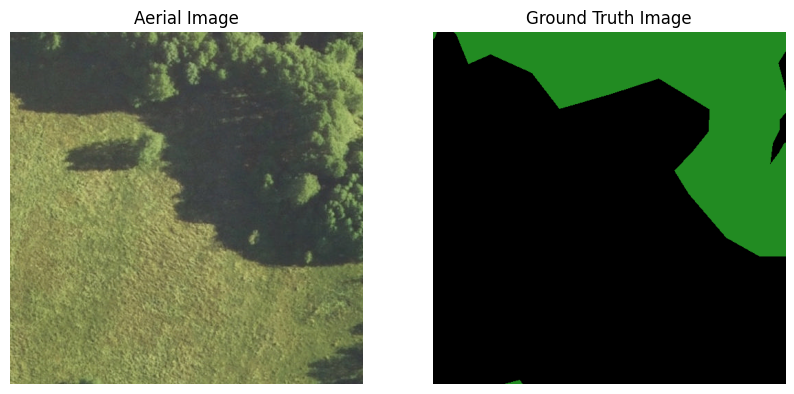

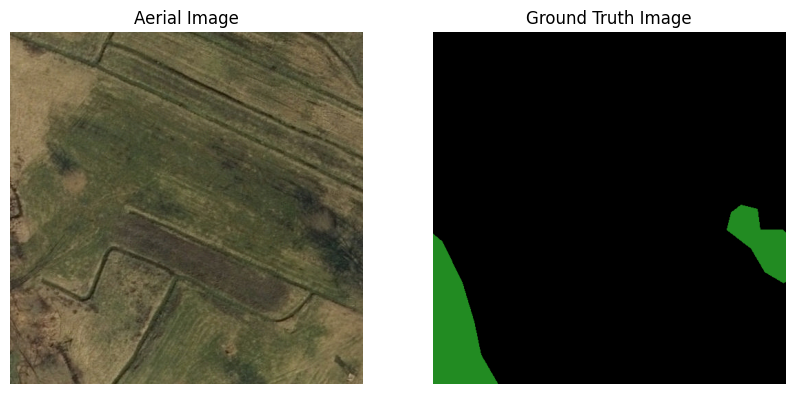

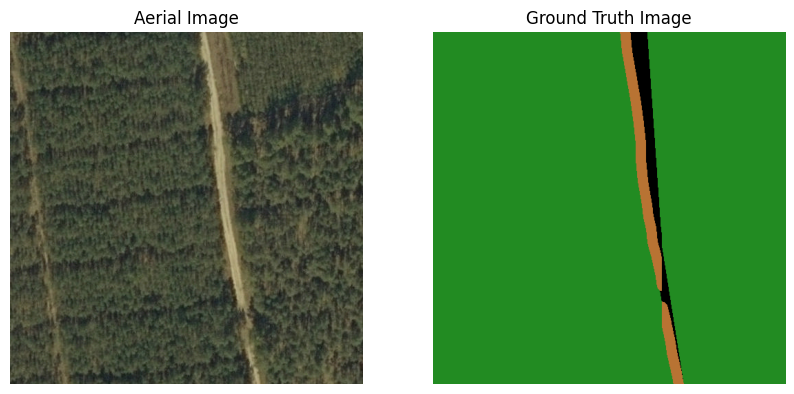

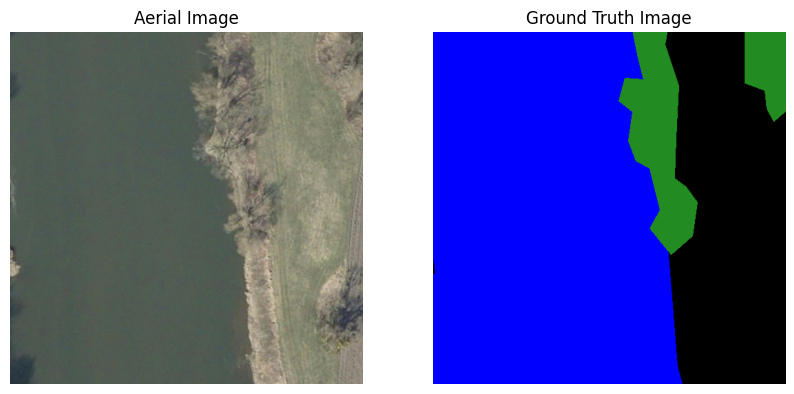

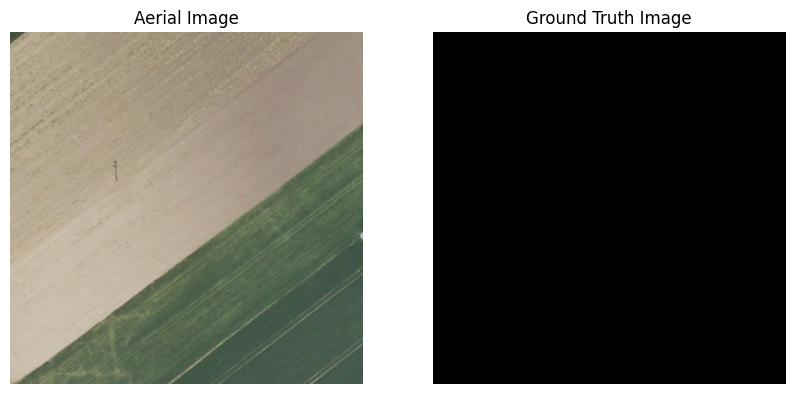

In [ ]:
aerial_folder = './../Data/train/sat/'
ground_truth_folder = './../Data/train/gt/'
visualize_image_pairs(aerial_folder, ground_truth_folder, num_samples=5)

In [ ]:
import os
import numpy as np
from PIL import Image

def filter_data_by_class(folder, class_name, threshold_percent):
    sat_folder = os.path.join(folder, "sat")
    gt_folder = os.path.join(folder, "gt")

    filtered_sat_files = []
    filtered_gt_files = []

    for filename in os.listdir(gt_folder):
        if filename.endswith(".tif") and filename.startswith("gt_"):
            gt_path = os.path.join(gt_folder, filename)
            sat_path = os.path.join(sat_folder, filename.replace("gt_", "sat_"))

            # Load ground truth mask
            gt_mask = np.array(Image.open(gt_path))

            # Calculate the percentage of the specified class
            class_percent = np.sum(gt_mask == class_name) / gt_mask.size * 100.0

            # Check if the class percentage is below the threshold
            if class_percent <= threshold_percent:
                filtered_gt_files.append(gt_path)
                filtered_sat_files.append(sat_path)

    return filtered_sat_files, filtered_gt_files

In [ ]:
# Images where "unlabeled" class is more than 100%
filtered_sat_files, filtered_gt_files = filter_data_by_class("./../Data/train/", class_name=0, threshold_percent=100)
# Now you can use filtered_sat_files and filtered_gt_files for loading your data
t_100 = len(filtered_sat_files)

filtered_sat_files, filtered_gt_files = filter_data_by_class("./../Data/train/", class_name=0, threshold_percent=90)
# Now you can use filtered_sat_files and filtered_gt_files for loading your data
t_90 = len(filtered_sat_files)

filtered_sat_files, filtered_gt_files = filter_data_by_class("./../Data/train/", class_name=0, threshold_percent=80)
# Now you can use filtered_sat_files and filtered_gt_files for loading your data
t_80 = len(filtered_sat_files)

filtered_sat_files, filtered_gt_files = filter_data_by_class("./../Data/train/", class_name=0, threshold_percent=75)
# Now you can use filtered_sat_files and filtered_gt_files for loading your data
t_75 = len(filtered_sat_files)

10062

In [ ]:
import pandas as pd

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Threshold", "Number of Files"])

# Threshold percentages
thresholds = [100, 90, 80, 75, 70, 60, 50]

# Iterate through threshold percentages and collect results
for threshold in thresholds:
    filtered_sat_files, _ = filter_data_by_class("./../Data/train/", class_name=0, threshold_percent=threshold)
    result = {"Threshold": f"t = {threshold}", "Number of Files": len(filtered_sat_files)}
    #results_df = results_df.append(result, ignore_index=True)
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

# Display the DataFrame
print(results_df)

  Threshold Number of Files
0   t = 100           10062
1    t = 90            6936
2    t = 80            5999
3    t = 75            5588
4    t = 70            5240
5    t = 60            4595
6    t = 50            4048


In [ ]:
results_df

,Threshold,Number of Files
0,t = 100,10062
1,t = 90,6936
2,t = 80,5999
3,t = 75,5588
4,t = 70,5240
5,t = 60,4595
6,t = 50,4048


In [ ]:
import os
import pandas as pd

def filter_and_count_files(data_folder, class_name, thresholds):
    results = []

    for threshold in thresholds:
        filtered_sat_files, _ = filter_data_by_class(data_folder, class_name, threshold)
        result = {"Threshold": f"t = {threshold}", "Number of Files": len(filtered_sat_files)}
        results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
thresholds = [100, 90, 80, 75, 70, 60, 50, 40, 30, 25, 20, 10, 0]

results_df = filter_and_count_files(data_folder, class_name, thresholds)
#print(results_df)
results_df

,Threshold,Number of Files
0,t = 100,10062
1,t = 90,6936
2,t = 80,5999
3,t = 75,5588
4,t = 70,5240
5,t = 60,4595
6,t = 50,4048
7,t = 40,3625
8,t = 30,3224
9,t = 25,2982


In [ ]:
import os
import shutil

def copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder):
    os.makedirs(os.path.join(destination_folder, "sat"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "gt"), exist_ok=True)

    for source_file in filtered_sat_files:
        destination_path = os.path.join(destination_folder, "sat", os.path.basename(source_file))
        shutil.copyfile(source_file, destination_path)

    for source_file in filtered_gt_files:
        destination_path = os.path.join(destination_folder, "gt", os.path.basename(source_file))
        shutil.copyfile(source_file, destination_path)

## Finding a better Class Distribution

Processing files:   0%|          | 0/891 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 891/891 [00:25<00:00, 35.59file/s]


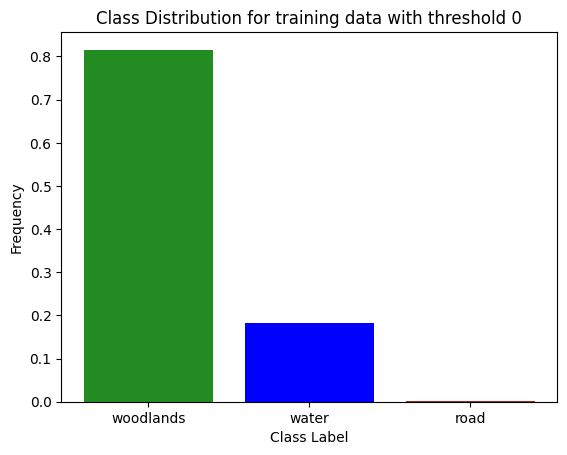

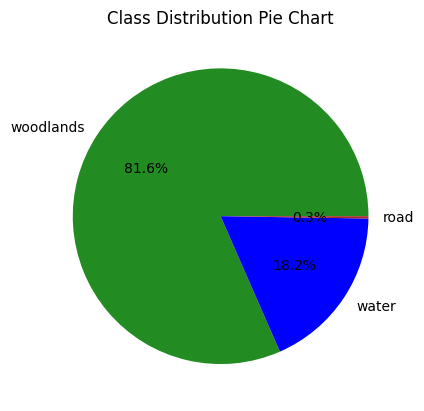

Class Distribution Summary:
woodlands: 190519115 samples, 81.57%
water: 42466382 samples, 18.18%
road: 584807 samples, 0.25%


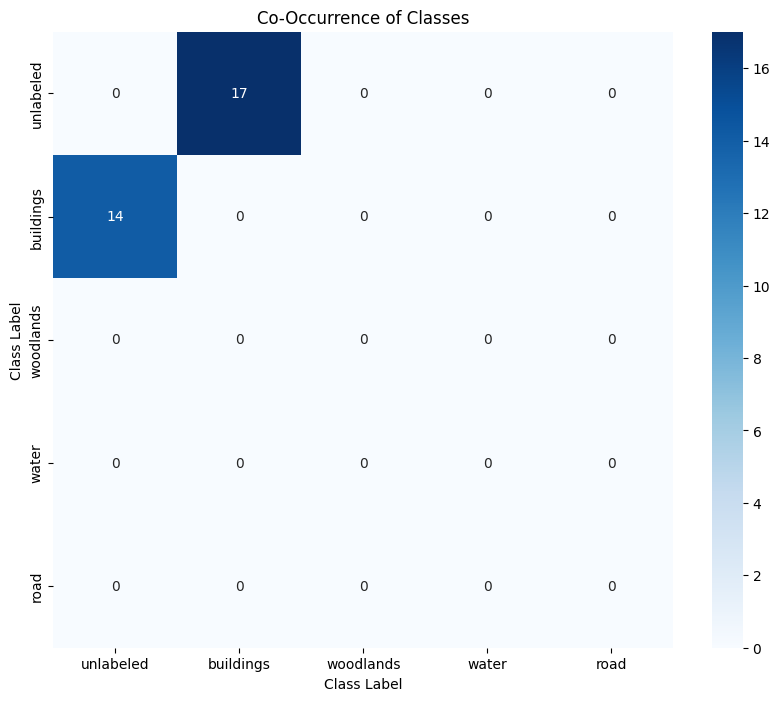

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 0  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")


Processing files:   0%|          | 0/2118 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 2118/2118 [01:18<00:00, 26.87file/s]


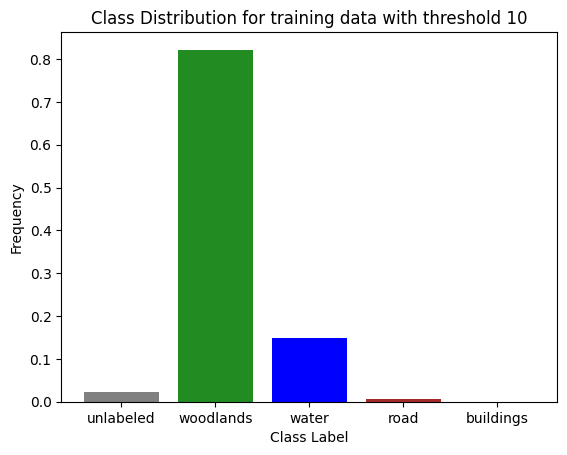

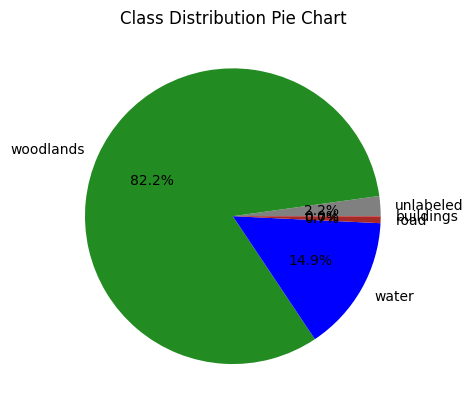

Class Distribution Summary:
unlabeled: 12157923 samples, 2.19%
woodlands: 456252895 samples, 82.18%
water: 82622260 samples, 14.88%
road: 4096089 samples, 0.74%
buildings: 91825 samples, 0.02%


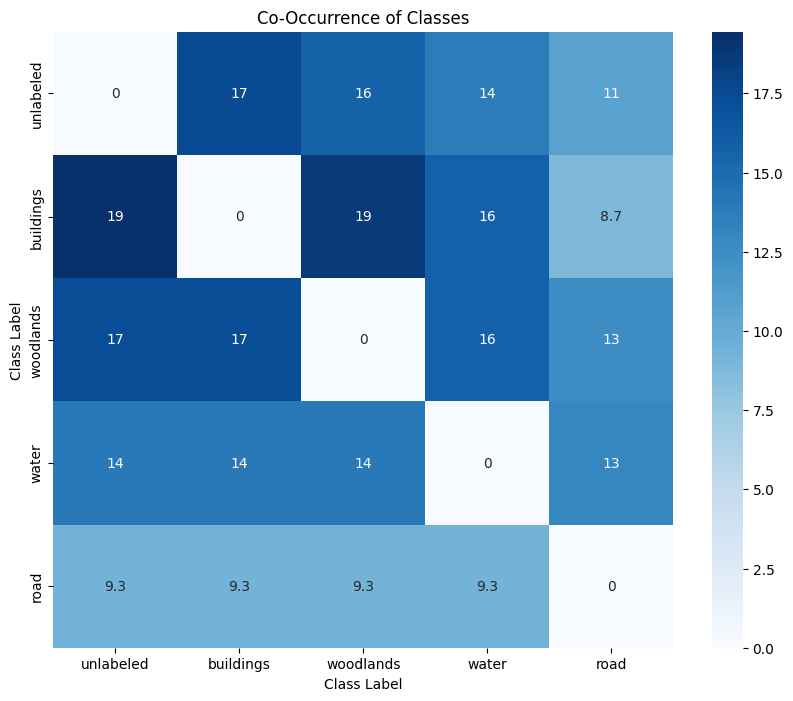

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 10  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/2720 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 2720/2720 [01:46<00:00, 25.64file/s]


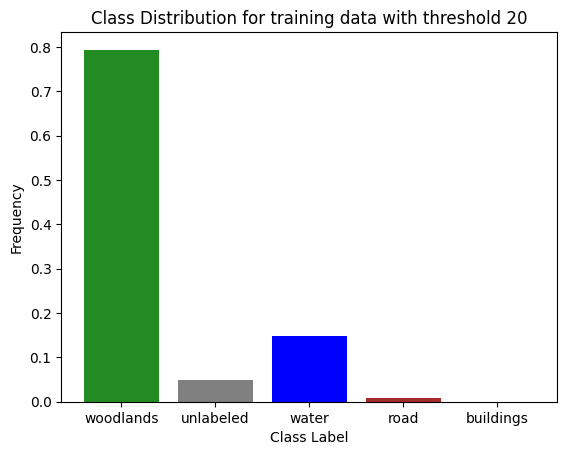

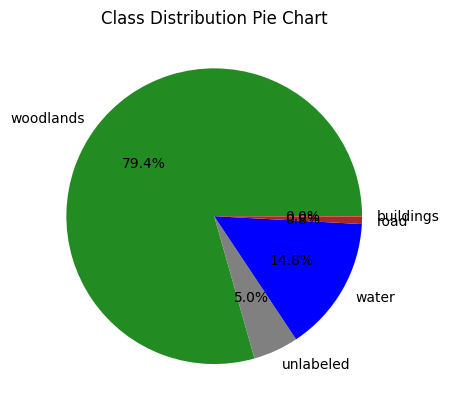

Class Distribution Summary:
woodlands: 566085918 samples, 79.39%
unlabeled: 35321323 samples, 4.95%
water: 105579956 samples, 14.81%
road: 5711142 samples, 0.80%
buildings: 333341 samples, 0.05%


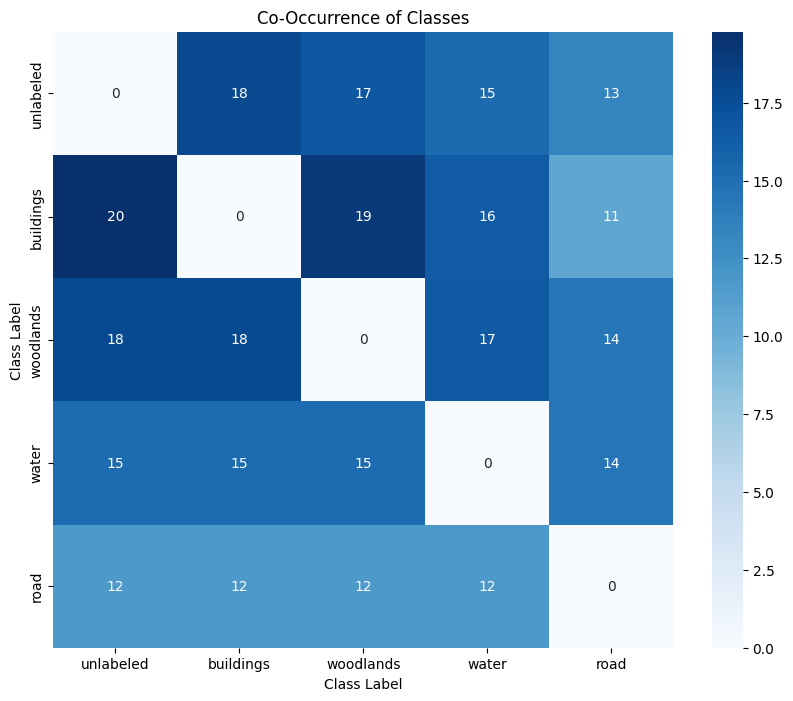

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 20  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/4048 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 4048/4048 [02:44<00:00, 24.54file/s]


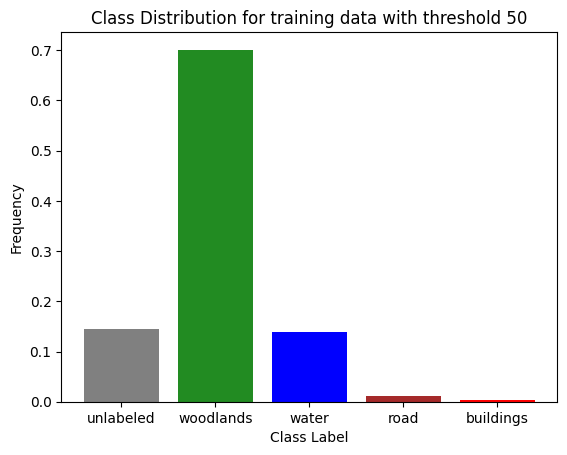

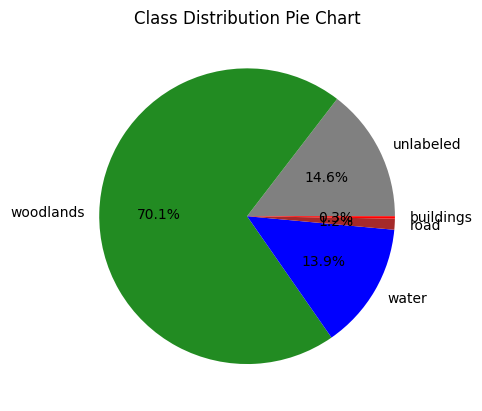

Class Distribution Summary:
unlabeled: 154703007 samples, 14.58%
woodlands: 743815857 samples, 70.09%
water: 147103468 samples, 13.86%
road: 12738675 samples, 1.20%
buildings: 2797905 samples, 0.26%


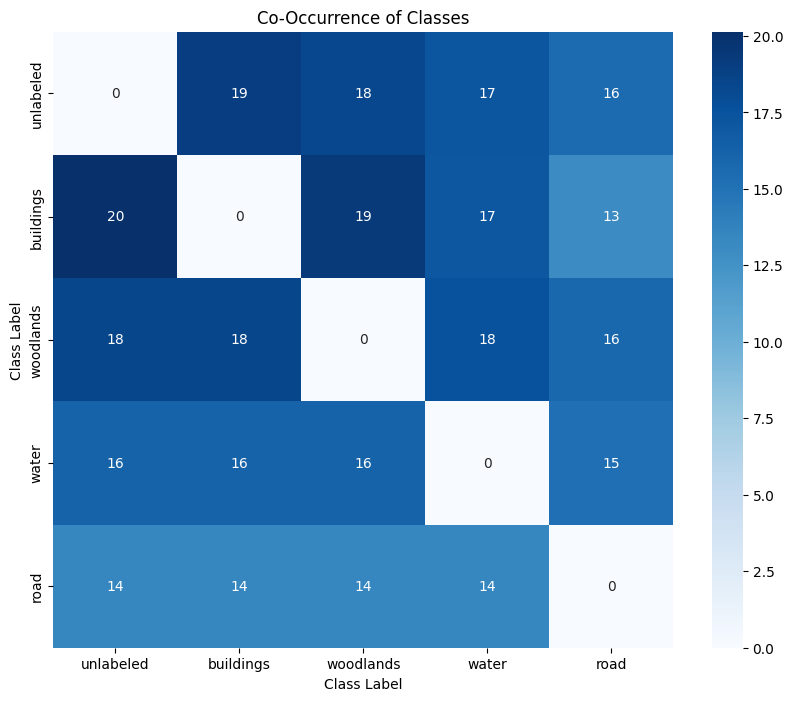

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 50  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/4595 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 4595/4595 [03:12<00:00, 23.85file/s]


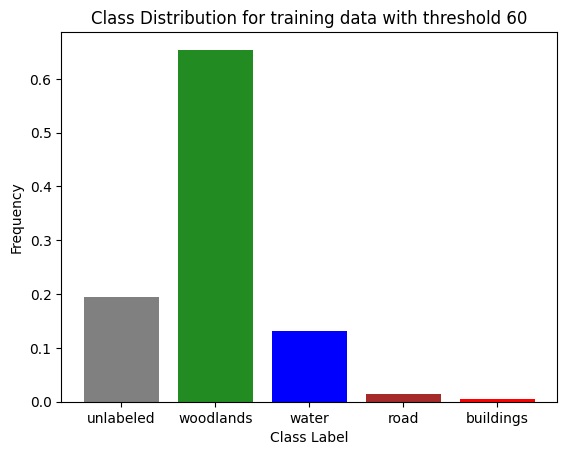

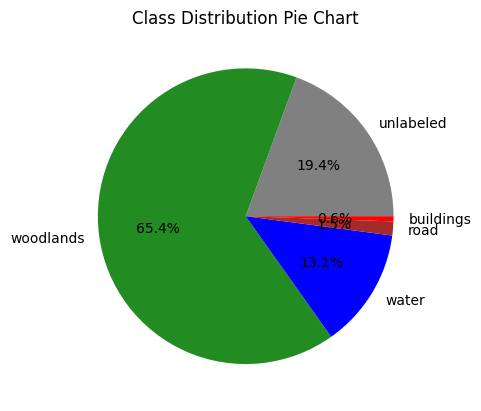

Class Distribution Summary:
unlabeled: 233827247 samples, 19.41%
woodlands: 787830045 samples, 65.40%
water: 157738095 samples, 13.10%
road: 18369471 samples, 1.53%
buildings: 6786822 samples, 0.56%


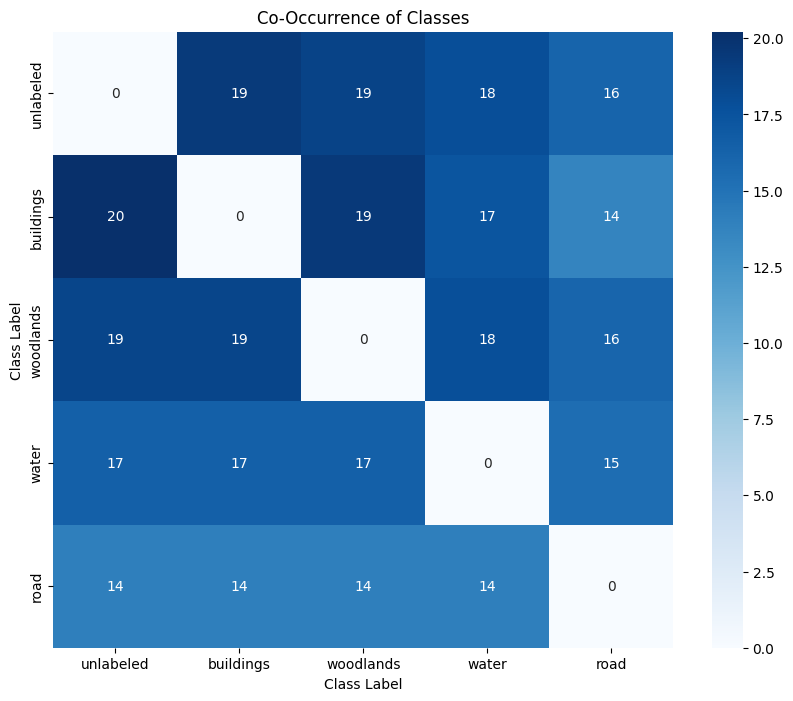

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 60  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/5240 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 5240/5240 [03:51<00:00, 22.59file/s]


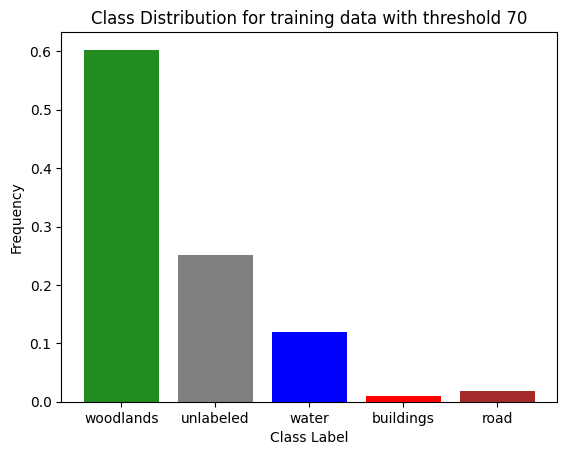

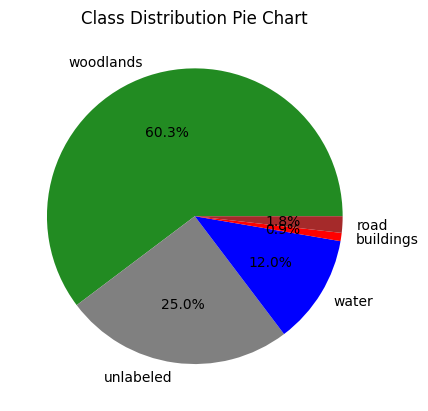

Class Distribution Summary:
woodlands: 827943904 samples, 60.27%
unlabeled: 343968857 samples, 25.04%
water: 164594740 samples, 11.98%
buildings: 12336675 samples, 0.90%
road: 24790384 samples, 1.80%


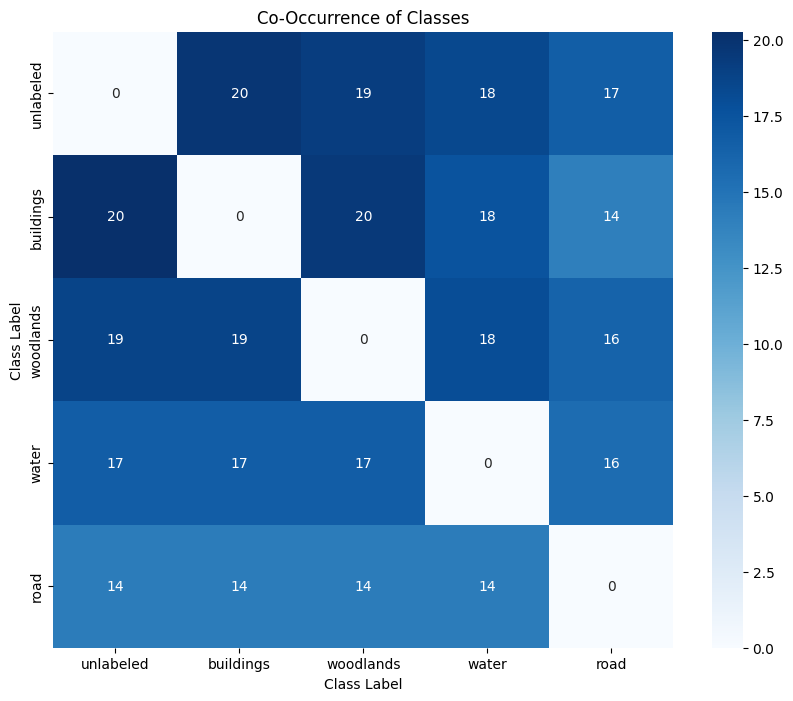

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 70  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/5588 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 5588/5588 [03:59<00:00, 23.30file/s]


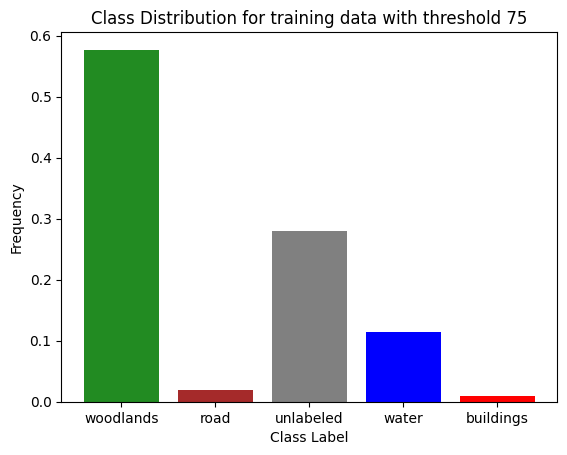

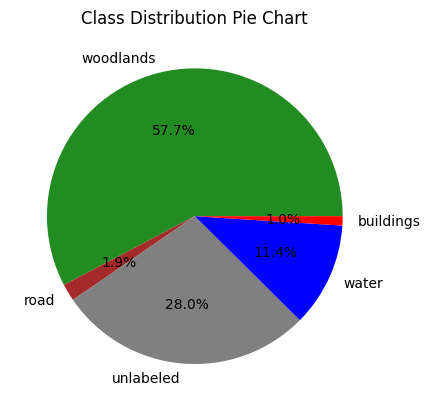

Class Distribution Summary:
woodlands: 845164687 samples, 57.70%
road: 27673958 samples, 1.89%
unlabeled: 410070525 samples, 27.99%
water: 167121847 samples, 11.41%
buildings: 14829655 samples, 1.01%


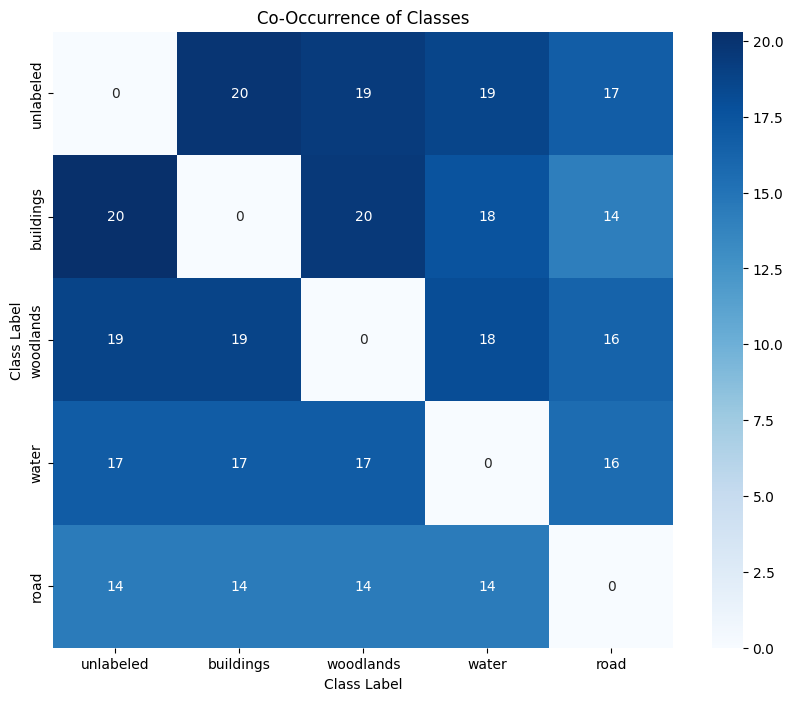

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 75  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/4618 [00:00<?, ?file/s]d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 4618/4618 [05:05<00:00, 15.12file/s]


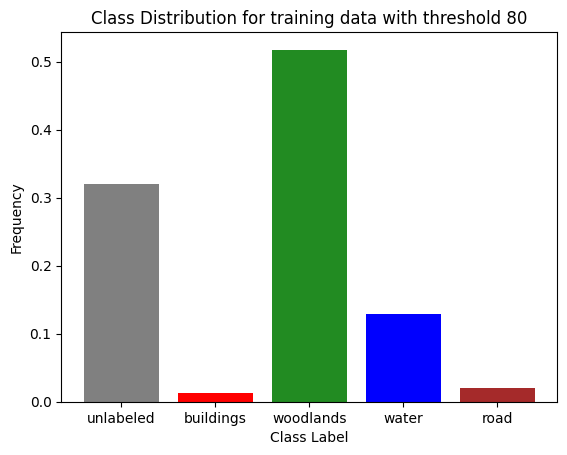

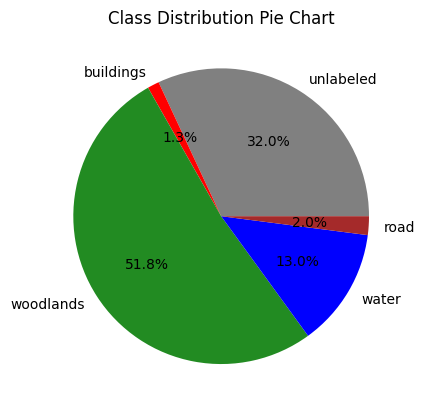

Class Distribution Summary:
unlabeled: 386874834 samples, 31.96%
buildings: 15468821 samples, 1.28%
woodlands: 626669319 samples, 51.77%
water: 156815293 samples, 12.95%
road: 24752725 samples, 2.04%


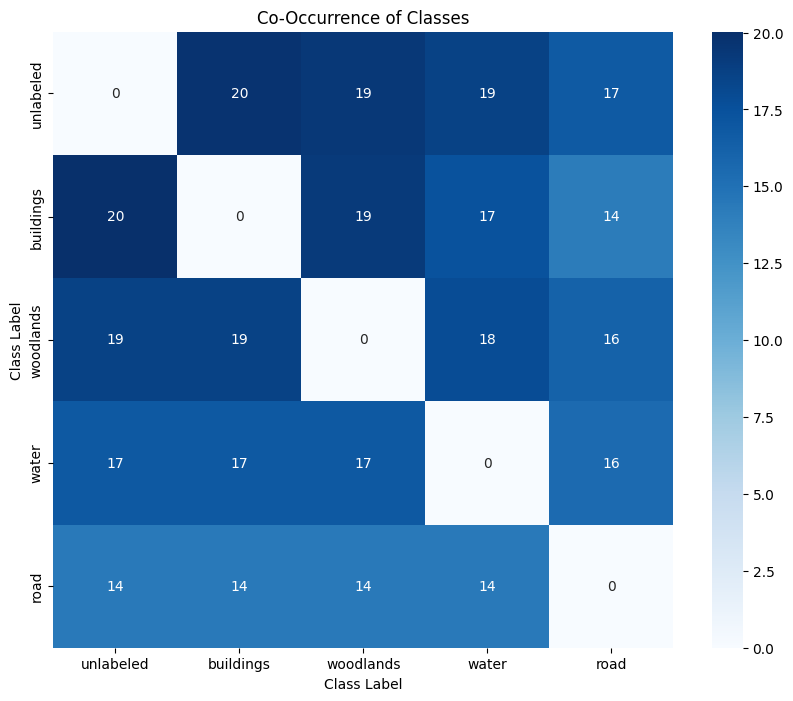

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 80  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/6936 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 6936/6936 [05:22<00:00, 21.49file/s]


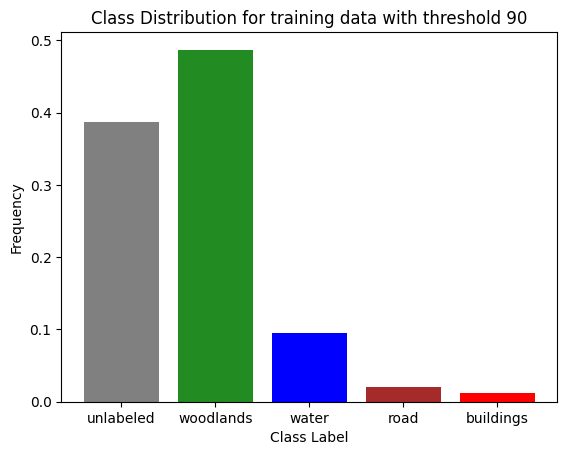

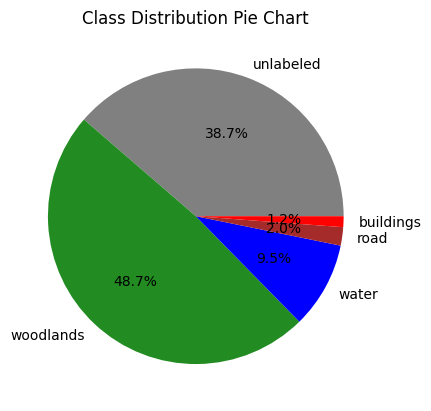

Class Distribution Summary:
unlabeled: 702905412 samples, 38.66%
woodlands: 885380455 samples, 48.69%
water: 171904159 samples, 9.45%
road: 36494428 samples, 2.01%
buildings: 21546330 samples, 1.19%


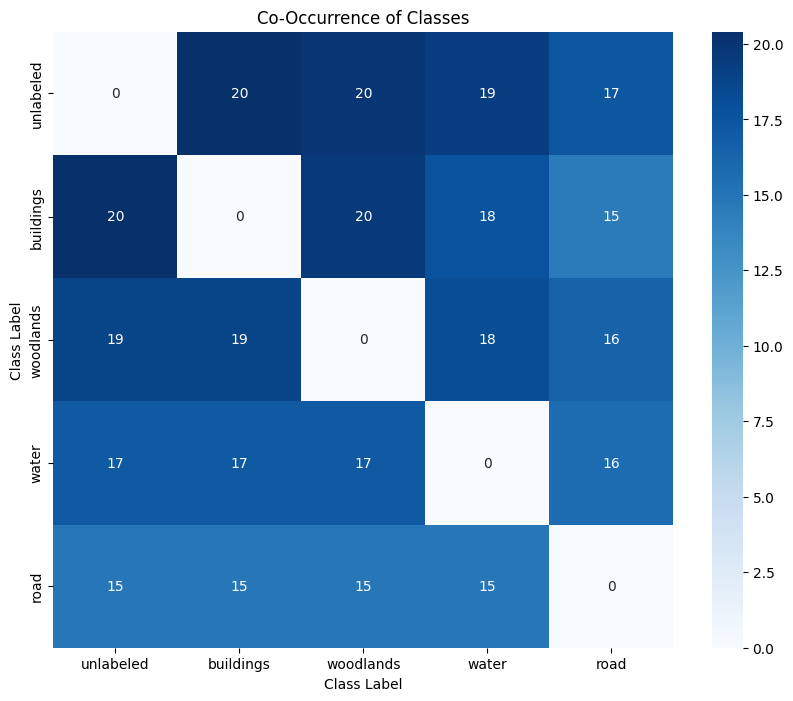

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 90  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/7213 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 7213/7213 [05:41<00:00, 21.13file/s]


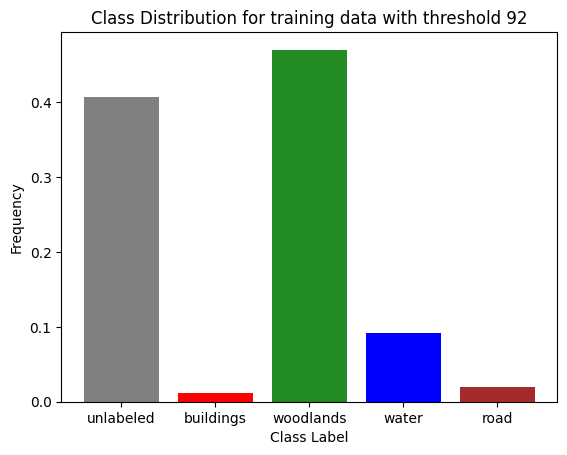

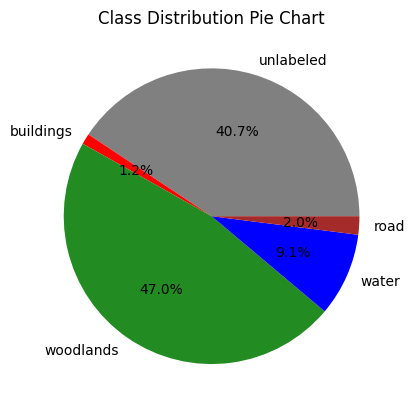

Class Distribution Summary:
unlabeled: 769048435 samples, 40.67%
buildings: 22174480 samples, 1.17%
woodlands: 889155908 samples, 47.02%
water: 172514649 samples, 9.12%
road: 37951200 samples, 2.01%


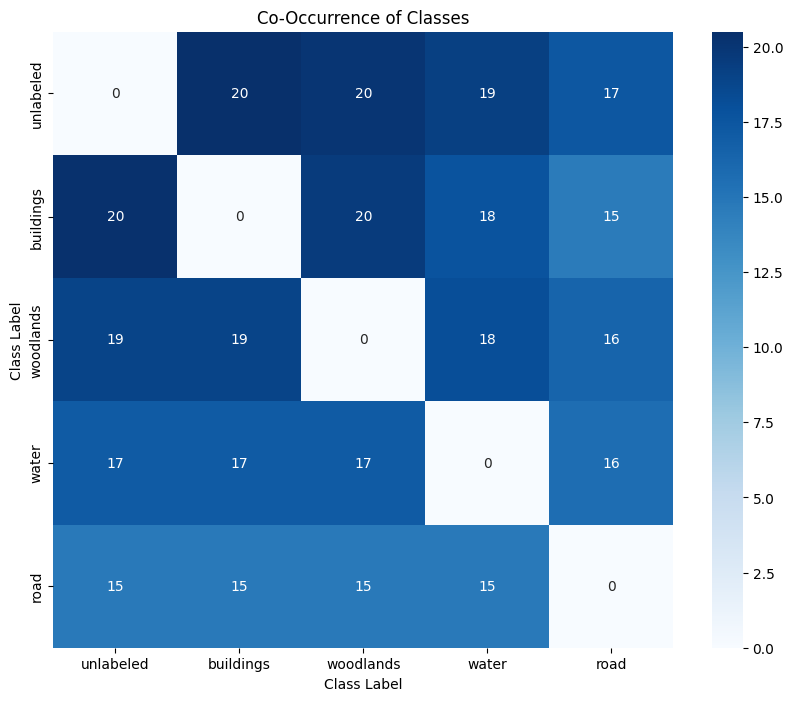

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 92  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

Processing files:   0%|          | 0/7640 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 7640/7640 [05:48<00:00, 21.89file/s]


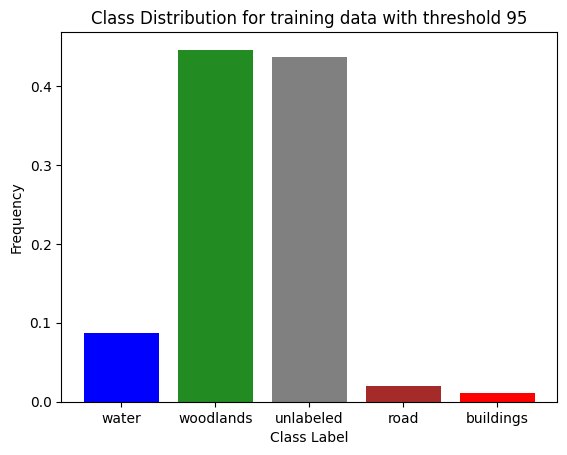

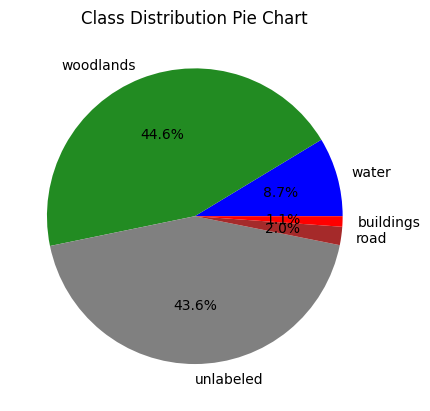

Class Distribution Summary:
water: 173304010 samples, 8.65%
woodlands: 892787930 samples, 44.58%
unlabeled: 873828684 samples, 43.63%
road: 39993542 samples, 2.00%
buildings: 22865994 samples, 1.14%


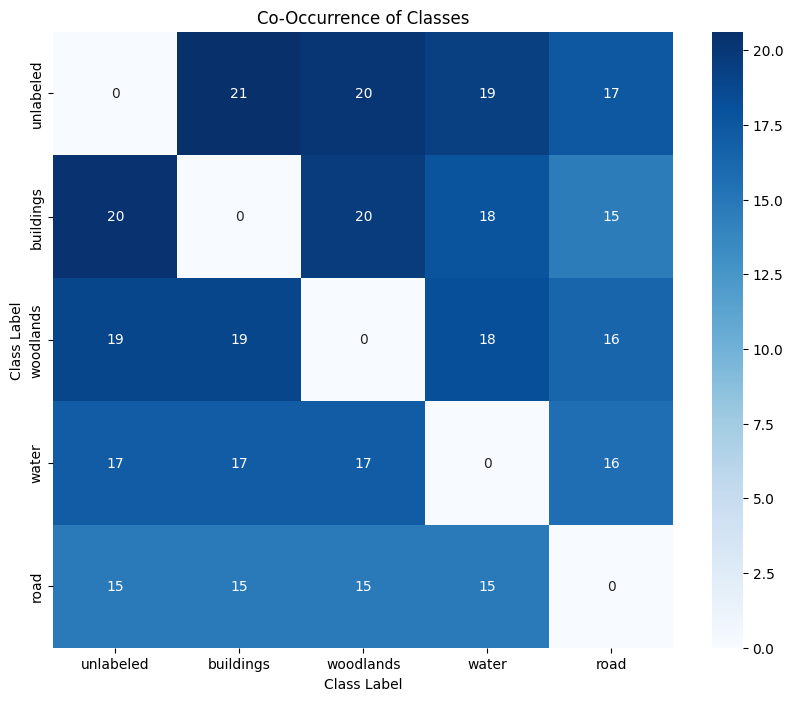

In [ ]:
data_folder = "./../Data/train/"
class_name = 0
threshold_percent = 95  # Change this to the desired threshold
filtered_sat_files, filtered_gt_files = filter_data_by_class(data_folder, class_name, threshold_percent)

destination_folder = f"./../Data_filtered_{threshold_percent}/train/"
copy_files_to_folder_structure(filtered_sat_files, filtered_gt_files, destination_folder)

# Define the path to the training ground truth folder
gt_folder = f"./../Data_filtered_{threshold_percent}/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold {threshold_percent}")

## Decision: threshold=80 may be the best

In [5]:
import pandas as pd

data = {
    "Threshold (%)": [0, 10, 20, 50, 60, 70, 75, 80, 90, 92, 95, 100],
    "Files": [891, 2118, 2720, 4048, 4595, 5240, 5588, 5999, 6936, 7213, 7640, 8388],
    "Unlabeled (%)": [0, 2.19, 4.95, 14.58, 19.41, 25.04, 27.99, 31.39, 38.66, 40.67, 43.63, 59.18],
    "Woodlands (%)": [81.57, 82.18, 79.39, 70.09, 65.40, 60.27, 57.70, 54.80, 48.69, 47.02, 44.58, 32.34],
    "Water (%)": [18.18, 14.88, 14.81, 13.86, 13.10, 11.98, 11.41, 10.76, 9.45, 9.12, 8.65, 5.86],
    "Roads (%)": [0.25, 0.74, 0.80, 1.20, 1.53, 1.80, 1.89, 1.95, 2.01, 2.01, 2.00, 1.69],
    "Buildings (%)": [0, 0.02, 0.05, 0.26, 0.56, 0.90, 1.01, 1.10, 1.19, 1.17, 1.14, 0.93]
}

df = pd.DataFrame(data)

# Format floats with two decimal places
df = df.style.format("{:.2f}", subset=df.columns[2:])

# Center align the values
df = df.set_table_styles([
    {'selector': 'td', 'props': [('text-align', 'center')]},
])

df

,Threshold (%),Files,Unlabeled (%),Woodlands (%),Water (%),Roads (%),Buildings (%)
0,0,891,0.00,81.57,18.18,0.25,0.00
1,10,2118,2.19,82.18,14.88,0.74,0.02
2,20,2720,4.95,79.39,14.81,0.80,0.05
3,50,4048,14.58,70.09,13.86,1.20,0.26
4,60,4595,19.41,65.40,13.10,1.53,0.56
5,70,5240,25.04,60.27,11.98,1.80,0.90
6,75,5588,27.99,57.70,11.41,1.89,1.01
7,80,5999,31.39,54.80,10.76,1.95,1.10
8,90,6936,38.66,48.69,9.45,2.01,1.19
9,92,7213,40.67,47.02,9.12,2.01,1.17


Processing files:   0%|          | 0/5999 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 5999/5999 [04:29<00:00, 22.26file/s]


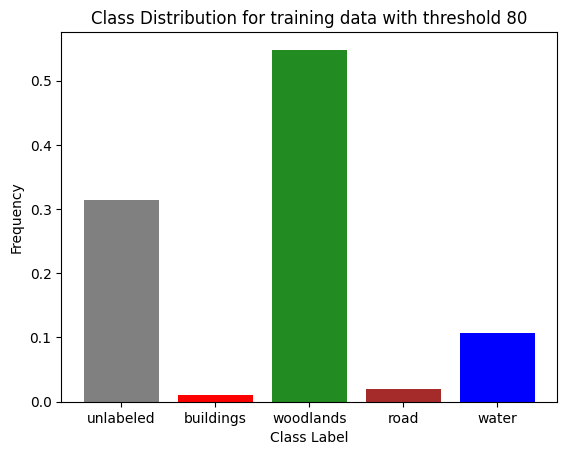

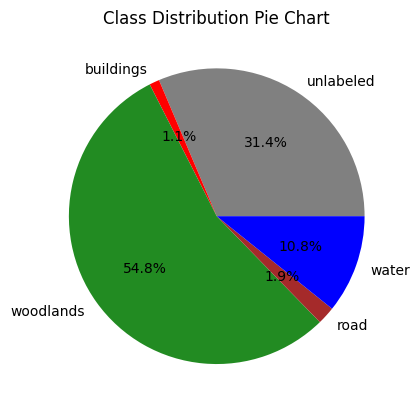

Class Distribution Summary:
unlabeled: 493629916 samples, 31.39%
buildings: 17274035 samples, 1.10%
woodlands: 861846209 samples, 54.80%
road: 30631834 samples, 1.95%
water: 169219862 samples, 10.76%


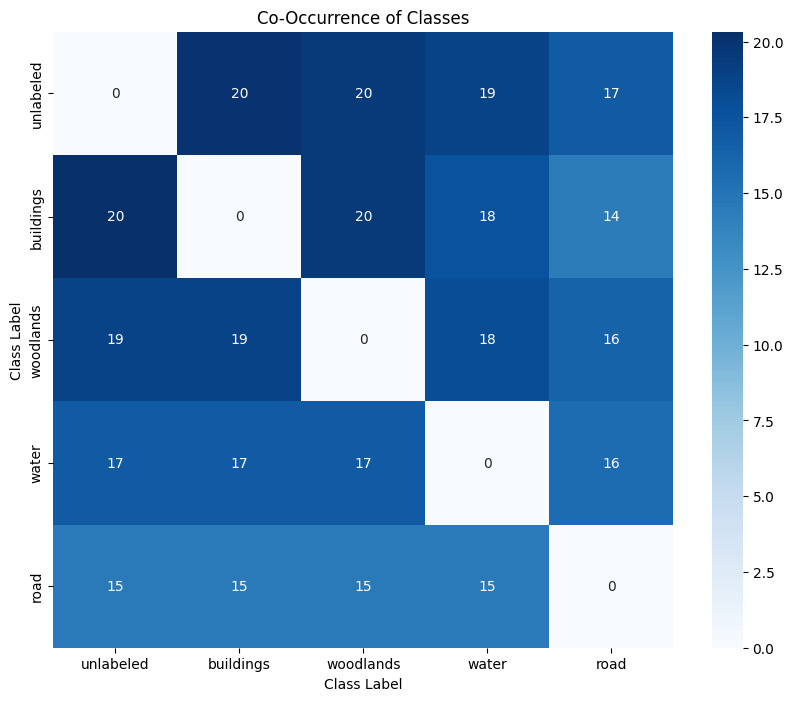

In [ ]:
gt_folder = f"./../Data_filtered_80/train/gt/"
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title=f"Class Distribution for training data with threshold 80")